<a href="https://colab.research.google.com/github/DyingTwice/MS/blob/main/MS_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimPy - Bike Sharing System
In Lab 2, we introduced the basics of modeling and simulation by creating a simplified bike-sharing system using basic Python classes. We modeled stations, bikes, and trips between stations with probabilities, and analyzed the system over a 30-minute period.

In Lab 3, we will take a step further by introducing SimPy, a powerful Python library for discrete-event simulation. SimPy allows us to model complex systems more efficiently and accurately. We will reimplement our bike-sharing system using SimPy and explore extensions and upgrades to enhance the system.


### Pip packages
Pip is python's built-in package manager - it helps us install libraries that are not packaged inside Python's vanilla distribution.

Perhaps the only pip command you need to know for this laboratory is pip install {package_name}. E.g. pip install simpy.
This will download the necessary prerequisites, install them and make the library available for use using python's module import functionality.


```
import simpy
```

The pip commands only work in the terminal/command line, they are not python code. Jupyter notebooks (and hence Google Colab) environments allow calling commands in the terminal by adding an exclamation mark as a prefix:
```
!pip install simpy
```


In [ ]:
!pip install simpy

SimPy is a process-based discrete-event simulation framework based on standard Python. It allows you to model systems where events occur at discrete points in time, making it ideal for simulating real-world processes like bike-sharing systems, queuing systems, network traffic, and more.

Keywords when working with simpy:

* Environment: Keep track of simulation time and schedule events.
* Processes: Simulate concurrent activities in the system.
* Events: Model the occurrence of incidents at specific times.
* Resources: Manage limited resources like bikes and docks.


In [ ]:
import simpy
import random
import matplotlib.pyplot as plt

# The Environment in SimPy manages the simulation time and handles event scheduling. It acts as the central controller of the simulation.
env = simpy.Environment()

# Processes are functions that yield events. They simulate the behavior of active components in the system, like customers, machines, or in our case, bikes and trips.
# Example of a simple process
def simple_process(env):
    while True:
        print(f"Time {env.now}: Process is running")
        yield env.timeout(1)  # Wait for 1 time unit


# To start a process in SimPy, you add it to the environment:
env.process(simple_process(env))


<Process(simple_process) object at 0x7a8e0c371de0>

SimPy provides **resource** classes to model limited capacity constraints. Resources represent entities like servers, parking spaces, or bikes.

* Resource: A generic resource with a limited number of slots.
* Container: Represents the production and consumption of a homogeneous, undistinguishable bulk (like water in a tank).
* Store: A resource where each item is distinct (e.g., individual bikes with unique IDs).

For our bike-sharing system, we can use Container to represent the number of bikes at a station.

### Reimplementing the Bike Share System with SimPy

Defining the System Components
* Stations: Entities with a capacity (number of docks) and a container for bikes.
* Bikes: Represented as tokens in containers; we don't need to model individual bikes.
* Trips: Processes that simulate the movement of bikes between stations.

In [ ]:
# Defining the Station Class
class Station:
    def __init__(self, env, name, capacity, init_bikes):
        self.env = env
        self.name = name
        self.capacity = capacity
        self.bikes = simpy.Container(env, init=init_bikes, capacity=capacity)

In [ ]:
# Defining the Bike Trip Process
def bike_trip(env, from_station, to_station, trip_duration):
    if from_station.bikes.level > 0:
        yield from_station.bikes.get(1)
        print(f"Time {env.now}: Bike taken from {from_station.name}")
    else:
        print(f"Time {env.now}: No bikes available at {from_station.name}")
        return  # Trip cannot proceed without a bike

    # Simulate the trip duration
    yield env.timeout(trip_duration)

    if to_station.bikes.level < to_station.capacity:
        yield to_station.bikes.put(1)
        print(f"Time {env.now}: Bike returned to {to_station.name}")
    else:
        print(f"Time {env.now}: No docks available at {to_station.name}, returning bike to {from_station.name}")
        yield env.timeout(trip_duration)
        if from_station.bikes.level > 0:
            yield from_station.bikes.put(1)
            print(f"Time {env.now}: Bike returned to {from_station.name}")
        # For simplicity, the bike is returned to original station - if there are no empty slots, we lose the bike

In [ ]:
# Defining the Trip Generation Process
"""
The function generate_trips continuously checks if trips should occur between stations based on specified probabilities.
For each possible trip, it generates a random number and compares it with the trip probability.
If a trip is to occur, it starts a bike_trip process.
"""
def generate_trips(env, prob_matrix):
    while True:
        # Decide whether a trip occurs based on probabilities
        for (from_station, to_station), prob in prob_matrix.items():
            if random.uniform(0, 1) < prob:
                trip_duration = 1  # Fixed trip duration for simplicity
                env.process(bike_trip(env, from_station, to_station, trip_duration))
        yield env.timeout(1)  # Wait for 1 minute before checking again

In [ ]:
# Setting Up Stations and Probabilities

# Create stations
upt_station = Station(env, "UPT", capacity=10, init_bikes=5)
center_station = Station(env, "Center", capacity=10, init_bikes=5)

stations = [upt_station, center_station]

# Define trip probabilities
prob_matrix = {
    (upt_station, center_station): 0.3,  # 30% chance per minute
    (center_station, upt_station): 0.5,  # 50% chance per minute
}


In [ ]:
# Running the Simulation

# Start the trip generation process
env.process(generate_trips(env, prob_matrix))

# Run the simulation for 30 minutes
env.run(until=30)

Time 0: Process is running
Time 1: Process is running
Time 1: Bike taken from UPT
Time 1: Bike taken from Center
Time 2: Process is running
Time 2: Bike taken from Center
Time 2: Bike returned to Center
Time 2: Bike returned to UPT
Time 3: Process is running
Time 3: Bike returned to UPT
Time 4: Process is running
Time 4: Bike taken from UPT
Time 5: Process is running
Time 5: Bike taken from Center
Time 5: Bike returned to Center
Time 6: Process is running
Time 6: Bike taken from UPT
Time 6: Bike returned to UPT
Time 7: Process is running
Time 7: Bike taken from Center
Time 7: Bike returned to Center
Time 8: Process is running
Time 8: Bike taken from Center
Time 8: Bike returned to UPT
Time 9: Process is running
Time 9: Bike returned to UPT
Time 10: Process is running
Time 11: Process is running
Time 12: Process is running
Time 12: Bike taken from UPT
Time 13: Process is running
Time 13: Bike taken from UPT
Time 13: Bike taken from Center
Time 13: Bike returned to Center
Time 14: Proces

**Collecting Data**

We need to record the number of bikes at each station over time for analysis. We'll create **a monitoring process** for this purpose.

In [ ]:
def monitor_stations(env, stations, bike_levels):
    while True:
        for station in stations:
            bike_levels[station.name].append((env.now, station.bikes.level))
        yield env.timeout(1)

In [ ]:
# Since we've added new processes, we should reset the environment and reinitialize everything.
env = simpy.Environment()

# Reinitialize stations
upt_station = Station(env, "UPT", capacity=10, init_bikes=5)
center_station = Station(env, "Center", capacity=10, init_bikes=5)
stations = [upt_station, center_station]

# Reinitialize the probability matrix
prob_matrix = {
    (upt_station, center_station): 0.3,
    (center_station, upt_station): 0.5,
}

# Reinitialize the bike_levels dictionary
bike_levels = {station.name: [] for station in stations}

# Start the processes
env.process(generate_trips(env, prob_matrix))
env.process(monitor_stations(env, stations, bike_levels))

# Run the simulation
env.run(until=30)

Time 1: Bike taken from UPT
Time 2: Bike taken from UPT
Time 2: Bike taken from Center
Time 2: Bike returned to Center
Time 3: Bike returned to Center
Time 3: Bike returned to UPT
Time 7: Bike taken from Center
Time 8: Bike returned to UPT
Time 9: Bike taken from Center
Time 10: Bike returned to UPT
Time 12: Bike taken from Center
Time 13: Bike returned to UPT
Time 15: Bike taken from UPT
Time 15: Bike taken from Center
Time 16: Bike taken from UPT
Time 16: Bike taken from Center
Time 16: Bike returned to Center
Time 16: Bike returned to UPT
Time 17: Bike taken from Center
Time 17: Bike returned to Center
Time 17: Bike returned to UPT
Time 18: Bike returned to UPT
Time 19: Bike taken from UPT
Time 20: Bike taken from UPT
Time 20: Bike taken from Center
Time 20: Bike returned to Center
Time 21: Bike taken from Center
Time 21: Bike returned to Center
Time 21: Bike returned to UPT
Time 22: Bike returned to UPT
Time 24: Bike taken from Center
Time 25: Bike taken from Center
Time 25: Bike r

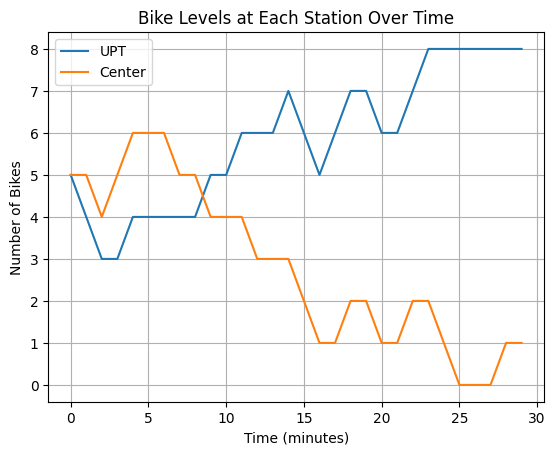

In [ ]:
# Plotting the bike levels over time
for station_name, levels in bike_levels.items():
    times, counts = zip(*levels)
    plt.plot(times, counts, label=station_name)

plt.xlabel('Time (minutes)')
plt.ylabel('Number of Bikes')
plt.title('Bike Levels at Each Station Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Extensions and Upgrades
Now that we have a working simulation, let's explore some extensions to make the system more realistic.

### Extension 1: Adding More Stations
Let's add a new station called "P700".

In [ ]:
# Since we've added new processes, we should reset the environment and reinitialize everything.
env = simpy.Environment()

# Reinitialize stations
upt_station = Station(env, "UPT", capacity=10, init_bikes=5)
center_station = Station(env, "Center", capacity=10, init_bikes=5)
P700_station = Station(env, "P700", capacity=12, init_bikes=7)

stations = [upt_station, center_station, P700_station]

# Reinitialize the probability matrix
prob_matrix = {
    (upt_station, center_station): 0.3,
    (center_station, upt_station): 0.5,
    (P700_station, upt_station): 0.4,
    (P700_station, center_station): 0.2,
    (upt_station, P700_station): 0.5,
    (center_station, P700_station): 0.3,
}

# Reinitialize the bike_levels dictionary
bike_levels = {station.name: [] for station in stations}

# Start the processes
env.process(generate_trips(env, prob_matrix))
env.process(monitor_stations(env, stations, bike_levels))

# Run the simulation
env.run(until=30)

Time 0: Bike taken from UPT
Time 0: Bike taken from Center
Time 1: Bike taken from Center
Time 1: Bike taken from P700
Time 2: Bike taken from Center
Time 3: Bike taken from Center
Time 3: Bike taken from P700
Time 4: Bike taken from Center
Time 4: Bike taken from UPT
Time 5: No bikes available at Center
Time 5: Bike taken from P700
Time 5: Bike taken from P700
Time 5: Bike taken from UPT
Time 6: No bikes available at Center
Time 6: Bike taken from UPT
Time 6: Bike taken from P700
Time 6: Bike taken from P700
Time 6: Bike taken from UPT
Time 7: Bike returned to Center
Time 7: Bike returned to P700
Time 7: Bike taken from Center
Time 7: Bike taken from P700
Time 8: Bike returned to Center
Time 8: Bike returned to UPT
Time 8: Bike taken from Center
Time 8: Bike taken from P700
Time 8: Bike taken from UPT
Time 9: No bikes available at Center
Time 9: No bikes available at P700
Time 10: No bikes available at Center
Time 10: No bikes available at P700
Time 10: No bikes available at UPT
Time 

### Extension 2: Introducing Variable Trip Durations
Instead of fixed trip durations, we can have random durations.

In [ ]:
# Defining the Trip Generation Process
"""
The function generate_trips continuously checks if trips should occur between stations based on specified probabilities.
For each possible trip, it generates a random number and compares it with the trip probability.
If a trip is to occur, it starts a bike_trip process.
"""
def generate_trips(env, prob_matrix):
    while True:
        # Decide whether a trip occurs based on probabilities
        for (from_station, to_station), prob in prob_matrix.items():
            if random.uniform(0, 1) < prob:
                trip_duration = random.randint(5, 10)  # Fixed trip duration for simplicity
                env.process(bike_trip(env, from_station, to_station, trip_duration))
        yield env.timeout(1)  # Wait for 1 minute before checking again

### Extension 3: Implementing Rebalancing
Introduce a process that periodically moves bikes to balance the stations.

In [ ]:
# Add stations rebalancing
# Defining the Bike Trip Process
def bike_trip(env, from_station, to_station, trip_duration):
    if from_station.bikes.level > 0:
        yield from_station.bikes.get(1)
        print(f"Time {env.now}: Bike taken from {from_station.name}")
    else:
        print(f"Time {env.now}: No bikes available at {from_station.name}")
        return  # Trip cannot proceed without a bike

    # Simulate the trip duration
    yield env.timeout(trip_duration)

    if to_station.bikes.level < to_station.capacity:
        yield to_station.bikes.put(1)
        print(f"Time {env.now}: Bike returned to {to_station.name}")
    else:
        print(f"Time {env.now}: No docks available at {to_station.name}, returning bike to {from_station.name}")
        yield env.timeout(trip_duration)
        if from_station.bikes.level > 0:
            yield from_station.bikes.put(1)
            print(f"Time {env.now}: Bike returned to {from_station.name}")
        # For simplicity, the bike is returned to original station - if there are no empty slots, we lose the bike
def rebalance_bikes(env, stations):
    while True:
        for station in stations:
          if station.bikes.level == 0:
            if max(bike_levels[station.name],





### Extension 4: Analyzing Unhappy Customers
Track the number of times a customer cannot rent or return a bike.

In [ ]:
# Add a global variable tracking unhappy customers and increment it on each new unhappy customer
unhappy_customers = 0

### Simulate over multiple runs and analyze average unhappy customers

In [ ]:
# Write your multi-run simulation & plotting code below

Ideas of things that can be analyzed to assess impact on results

* Change the initial number of bikes at each station.
* Adjust the trip probabilities in the prob_matrix.
* Add more stations or different rebalancing strategies.